In [ ]:
from collections import Counter, OrderedDict
import ipywidgets as widgets
import itertools
import json
import pandas as pd
from urllib.request import urlopen
import numpy as np

In [ ]:
union_df = pd.read_csv("master_catmodel_dataset_union_decoded.csv")
#majority_df = pd.read_csv("master_catmodel_dataset_majority_decoded.csv")
df = union_df
df['category'] = df['category'].apply(lambda x: eval(x))
df.head()

,segment_text,category
0,Privacy Policy Sci-News.com is committed to ...,"[Policy Change, Introductory/Generic]"
1,Information that Sci-News.com May Collect Onli...,[First Party Collection/Use]
2,"- if you contact us, we may keep a record of t...","[First Party Collection/Use, Data Retention]"
3,- details of your visits to our site including...,[First Party Collection/Use]
4,Sci-News.com does not knowingly collect or sol...,"[International and Specific Audiences, Privacy..."


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download('stopwords')
STOPWORDS = stopwords.words('english')
porter = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text, lower=True, stem=False, 
               filters="[!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~]", 
               stopwords=STOPWORDS):
    """Conditional preprocessing on our text unique to our task."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords) + r')\b\s*')
    text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub(filters, r"", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip()

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Stemming
    if stem:
        text = " ".join([porter.stem(word) for word in text.split(' ')])

    return text

In [ ]:
# Apply to dataframe
original_df = df.copy()
df.segment_text = df.segment_text.apply(preprocess, lower=True, stem=False)
print (f"{original_df.segment_text.values[0]}\n{df.segment_text.values[0]}")

Privacy Policy   Sci-News.com is committed to protecting and respecting your privacy. To better inform you of our policy concerning user privacy, we have adopted the following terms. Please note that these terms are subject to change, and any such changes will be included on this page.  
privacy policy sci news com committed protecting respecting privacy better inform policy concerning user privacy adopted following terms please note terms subject change changes included page


In [ ]:
import numpy as np
import random

In [ ]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [ ]:
# Get data
X = df.segment_text.to_numpy()
y = df.category

In [ ]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(list(itertools.chain.from_iterable(y)))
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        y_one_hot = np.zeros((len(y), len(self.class_to_index)), dtype=int)
        for i, item in enumerate(y):
            for class_ in item:
                y_one_hot[i][self.class_to_index[class_]] = 1
        return y_one_hot

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            indices = np.where(item == 1)[0]
            classes.append([self.index_to_class[index] for index in indices])
        return classes

    def save(self, fp):
        with open(fp, 'w') as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, 'r') as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [ ]:
label_encoder.class_to_index

{'Data Retention': 0,
 'Data Security': 1,
 'Do Not Track': 2,
 'First Party Collection/Use': 3,
 'International and Specific Audiences': 4,
 'Introductory/Generic': 5,
 'Policy Change': 6,
 'Practice not covered': 7,
 'Privacy contact information': 8,
 'Third Party Sharing/Collection': 9,
 'User Access, Edit and Deletion': 10,
 'User Choice/Control': 11}

In [ ]:
# Sample
label_encoder.encode([["Data Retention", "International and Specific Audiences"]])

array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

(3776, 12)


In [ ]:
!pip install scikit-multilearn==0.2.0 -q

     |████████████████████████████████| 89 kB 5.6 MB/s 


In [ ]:
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

In [ ]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [ ]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)

In [ ]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

train: 2643 (0.70)
remaining: 1133 (0.30)


In [ ]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 2643 (0.70)
val: 566 (0.15)
test: 567 (0.15)


In [ ]:
# Get counts for each class
counts = {}
counts['train_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts['val_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts['test_counts'] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [ ]:
# View distributions
pd.DataFrame({
    "Train": counts["train_counts"],
    "Val": counts["val_counts"],
    "Test": counts["test_counts"]
}).T.fillna(0)

,"(9,)","(4,)","(5,)","(11,)","(6,)","(10,)","(8,)","(1,)","(7,)","(3,)","(0,)","(2,)"
Train,850,233,576,450,138,157,216,257,460,1062,106,23
Val,180,69,127,80,29,35,49,57,88,218,21,4
Test,156,51,110,102,25,38,58,61,94,239,29,5


In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
dist_df = pd.DataFrame({
    "Train": counts["train_counts"],
    "Val": counts["val_counts"],
    "Test": counts["test_counts"]
}).T.fillna(0)
dist_df

,"(9,)","(4,)","(5,)","(11,)","(6,)","(10,)","(8,)","(1,)","(7,)","(3,)","(0,)","(2,)"
Train,850,233,576,450,138,157,216,257,460,1062,106,23
Val,840,322,592,373,135,163,228,266,410,1017,98,18
Test,728,238,513,476,116,177,270,284,438,1115,135,23


In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

25.436014824564612

In [ ]:
from skmultilearn.model_selection import IterativeStratification

In [ ]:
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

In [ ]:
# Get data
X = df.segment_text.to_numpy()
y = df.category

In [ ]:
# Binarize y
label_encoder = LabelEncoder()
label_encoder.fit(y)
y = label_encoder.encode(y)

In [ ]:
# Split
X_train, X_, y_train, y_ = iterative_train_test_split(
    X, y, train_size=train_size)
X_val, X_test, y_val, y_test = iterative_train_test_split(
    X_, y_, train_size=0.5)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 2645 (0.70)
val: 574 (0.15)
test: 557 (0.15)


In [ ]:
# Get counts for each class
counts = {}
counts["train_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_train, order=1) for combination in row)
counts["val_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_val, order=1) for combination in row)
counts["test_counts"] = Counter(str(combination) for row in get_combination_wise_output_matrix(
    y_test, order=1) for combination in row)

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
# View distributions
pd.DataFrame({
    "Train": counts["train_counts"],
    "Val": counts["val_counts"],
    "Test": counts["test_counts"]
}).T.fillna(0)

,"(0,)","(3,)","(5,)","(11,)","(8,)","(7,)","(9,)","(6,)","(1,)","(10,)","(2,)","(4,)"
Train,109,1063,569,442,226,449,830,134,262,161,22,247
Val,116,1064,569,443,228,448,830,135,266,163,32,247
Test,102,1064,569,443,224,452,830,135,261,158,14,247


In [ ]:
dist_df = pd.DataFrame({
    'train': counts['train_counts'],
    'val': counts['val_counts'],
    'test': counts['test_counts']
}).T.fillna(0)

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

1.8367484617086676

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"segment_text": X_train, "category": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"segment_text": X_val, "category": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"segment_text": X_test, "category": label_encoder.decode(y_test)})
train_df.head()

,segment_text,category
0,contact us may keep record correspondence,"[Data Retention, First Party Collection/Use]"
1,use cookies sci news com uses cookie technolog...,[First Party Collection/Use]
2,consent rights using sci news com consent coll...,"[Introductory/Generic, User Choice/Control]"
3,contact us inquiries privacy policy implementa...,[Privacy contact information]
4,privacy statement covers site new www redorbit...,[Introductory/Generic]


In [ ]:
!pip install nlpaug==1.1.0 transformers==3.0.2 -q
!pip install snorkel==0.9.7 -q

     |████████████████████████████████| 380 kB 11.7 MB/s 
     |████████████████████████████████| 769 kB 46.0 MB/s 
     |████████████████████████████████| 895 kB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 43.4 MB/s 
     |████████████████████████████████| 3.0 MB 43.9 MB/s 
     |████████████████████████████████| 145 kB 11.1 MB/s 
     |████████████████████████████████| 3.8 MB 48.1 MB/s 
     |████████████████████████████████| 1.7 MB 41.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires tensorboard~=2.6, but you have tensorboard 1.15.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

In [ ]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import torch

In [ ]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [ ]:
def get_data_splits(df, train_size=0.7):
    """"""
    # Get data
    X = df.segment_text.to_numpy()
    y = df.category

    # Binarize y
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    y = label_encoder.encode(y)

    # Split
    X_train, X_, y_train, y_ = iterative_train_test_split(
        X, y, train_size=train_size)
    X_val, X_test, y_val, y_test = iterative_train_test_split(
        X_, y_, train_size=0.5)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [ ]:
class Trainer(object):
    def __init__(self, model, device, loss_fn=None, optimizer=None, scheduler=None):

        # Set params
        self.model = model
        self.device = device
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler

    def train_step(self, dataloader):
        """Train step."""
        # Set model to train mode
        self.model.train()
        loss = 0.0

        # Iterate over train batches
        for i, batch in enumerate(dataloader):

            # Step
            batch = [item.to(self.device) for item in batch]  # Set device
            inputs, targets = batch[:-1], batch[-1]
            self.optimizer.zero_grad()  # Reset gradients
            z = self.model(inputs)  # Forward pass
            J = self.loss_fn(z, targets)  # Define loss
            J.backward()  # Backward pass
            self.optimizer.step()  # Update weights

            # Cumulative Metrics
            loss += (J.detach().item() - loss) / (i + 1)

        return loss

    def eval_step(self, dataloader):
        """Validation or test step."""
        # Set model to eval mode
        self.model.eval()
        loss = 0.0
        y_trues, y_probs = [], []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Step
                batch = [item.to(self.device) for item in batch]  # Set device
                inputs, y_true = batch[:-1], batch[-1]
                z = self.model(inputs)  # Forward pass
                J = self.loss_fn(z, y_true).item()

                # Cumulative Metrics
                loss += (J - loss) / (i + 1)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)
                y_trues.extend(y_true.cpu().numpy())

        return loss, np.vstack(y_trues), np.vstack(y_probs)

    def predict_step(self, dataloader):
        """Prediction step."""
        # Set model to eval mode
        self.model.eval()
        y_probs = []

        # Iterate over val batches
        with torch.inference_mode():
            for i, batch in enumerate(dataloader):

                # Forward pass w/ inputs
                inputs, targets = batch[:-1], batch[-1]
                z = self.model(inputs)

                # Store outputs
                y_prob = torch.sigmoid(z).cpu().numpy()
                y_probs.extend(y_prob)

        return np.vstack(y_probs)
    
    def train(self, num_epochs, patience, train_dataloader, val_dataloader, 
              tolerance=1e-5):
        best_val_loss = np.inf
        for epoch in range(num_epochs):
            # Steps
            train_loss = self.train_step(dataloader=train_dataloader)
            val_loss, _, _ = self.eval_step(dataloader=val_dataloader)
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss - tolerance:
                best_val_loss = val_loss
                best_model = self.model
                _patience = patience  # reset _patience
            else:
                _patience -= 1
            if not _patience:  # 0
                print("Stopping early!")
                break

            # Logging
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}, "
                f"lr: {self.optimizer.param_groups[0]['lr']:.2E}, "
                f"_patience: {_patience}"
            )
        return best_model

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.segment_text = preprocessed_df.segment_text.apply(preprocess, lower=True, stem=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)

In [ ]:
# Tf-idf
vectorizer = TfidfVectorizer()
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)
print (X_train[0]) # scipy.sparse.csr_matrix

contact us may keep record correspond
(2645, 3951)
  (0, 1075)	0.6252027038132683
  (0, 2955)	0.45641397661986727
  (0, 2059)	0.4731453820827312
  (0, 2252)	0.17105281702859856
  (0, 3711)	0.2322101765874832
  (0, 1032)	0.306203651480832


In [ ]:
def fit_and_evaluate(model):
    """Fit and evaluate each model."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    return {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}

In [ ]:
# Models
performance = {}
performance["logistic-regression"] = fit_and_evaluate(OneVsRestClassifier(
    LogisticRegression(), n_jobs=1))
performance["k-nearest-neighbors"] = fit_and_evaluate(
    KNeighborsClassifier())
performance["random-forest"] = fit_and_evaluate(
    RandomForestClassifier(n_jobs=-1))
performance["gradient-boosting-machine"] = fit_and_evaluate(OneVsRestClassifier(
    GradientBoostingClassifier()))
performance["support-vector-machine"] = fit_and_evaluate(OneVsRestClassifier(
    LinearSVC(), n_jobs=-1))
print (json.dumps(performance, indent=2))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{
  "logistic-regression": {
    "precision": 0.8231629875553147,
    "recall": 0.4840041279669763,
    "f1": 0.5774641858092064
  },
  "k-nearest-neighbors": {
    "precision": 0.7065588796297275,
    "recall": 0.5376676986584107,
    "f1": 0.5969746431695283
  },
  "random-forest": {
    "precision": 0.8234288900533516,
    "recall": 0.44272445820433437,
    "f1": 0.5438723041094697
  },
  "gradient-boosting-machine": {
    "precision": 0.7739622179381892,
    "recall": 0.5510835913312694,
    "f1": 0.6275918306971963
  },
  "support-vector-machine": {
    "precision": 0.7556479929439904,
    "recall": 0.6140350877192983,
    "f1": 0.6679964511467538
  }
}


# CNN

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Set seeds
set_seeds()

In [ ]:
# Get data splits
preprocessed_df = df.copy()
preprocessed_df.segment_text = preprocessed_df.segment_text.apply(preprocess, lower=True)
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = get_data_splits(preprocessed_df)
X_test_raw = X_test  # use for later

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"segment_text": X_train, "category": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"segment_text": X_val, "category": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"segment_text": X_test, "category": label_encoder.decode(y_test)})

In [ ]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


In [ ]:
class Tokenizer(object):
    def __init__(self, char_level, num_tokens=None, 
                 pad_token="<PAD>", oov_token="<UNK>",
                 token_to_index=None):
        self.char_level = char_level
        self.separator = '' if self.char_level else ' '
        if num_tokens: num_tokens -= 2 # pad + unk tokens
        self.num_tokens = num_tokens
        self.pad_token = pad_token
        self.oov_token = oov_token
        if not token_to_index:
            token_to_index = {pad_token: 0, oov_token: 1}
        self.token_to_index = token_to_index
        self.index_to_token = {v: k for k, v in self.token_to_index.items()}

    def __len__(self):
        return len(self.token_to_index)

    def __str__(self):
        return f"<Tokenizer(num_tokens={len(self)})>"

    def fit_on_texts(self, texts):
        if not self.char_level:
            texts = [text.split(" ") for text in texts]
        all_tokens = [token for text in texts for token in text]
        counts = Counter(all_tokens).most_common(self.num_tokens)
        self.min_token_freq = counts[-1][1]
        for token, count in counts:
            index = len(self)
            self.token_to_index[token] = index
            self.index_to_token[index] = token
        return self

    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            if not self.char_level:
                text = text.split(' ')
            sequence = []
            for token in text:
                sequence.append(self.token_to_index.get(
                    token, self.token_to_index[self.oov_token]))
            sequences.append(np.asarray(sequence))
        return sequences

    def sequences_to_texts(self, sequences):
        texts = []
        for sequence in sequences:
            text = []
            for index in sequence:
                text.append(self.index_to_token.get(index, self.oov_token))
            texts.append(self.separator.join([token for token in text]))
        return texts

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {
                "char_level": self.char_level,
                "oov_token": self.oov_token,
                "token_to_index": self.token_to_index
            }
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Tokenize
char_level = True
tokenizer = Tokenizer(char_level=char_level)
tokenizer.fit_on_texts(texts=X_train)
vocab_size = len(tokenizer)
print (tokenizer)

<Tokenizer(num_tokens=39)>


In [ ]:
tokenizer.token_to_index

{' ': 2,
 '0': 30,
 '1': 28,
 '2': 31,
 '3': 32,
 '4': 35,
 '5': 33,
 '6': 38,
 '7': 37,
 '8': 34,
 '9': 36,
 '<PAD>': 0,
 '<UNK>': 1,
 'a': 6,
 'b': 22,
 'c': 11,
 'd': 13,
 'e': 3,
 'f': 17,
 'g': 18,
 'h': 21,
 'i': 4,
 'j': 29,
 'k': 24,
 'l': 12,
 'm': 15,
 'n': 10,
 'o': 9,
 'p': 14,
 'q': 25,
 'r': 8,
 's': 5,
 't': 7,
 'u': 16,
 'v': 20,
 'w': 23,
 'x': 26,
 'y': 19,
 'z': 27}

In [ ]:
# Convert texts to sequences of indices
X_train = np.array(tokenizer.texts_to_sequences(X_train))
X_val = np.array(tokenizer.texts_to_sequences(X_val))
X_test = np.array(tokenizer.texts_to_sequences(X_test))
preprocessed_text = tokenizer.sequences_to_texts([X_train[0]])[0]
print ("Text to indices:\n"
    f"  (preprocessed) → {preprocessed_text}\n"
    f"  (tokenized) → {X_train[0]}")

Text to indices:
  (preprocessed) → contact us may keep record correspondence
  (tokenized) → [11  9 10  7  6 11  7  2 16  5  2 15  6 19  2 24  3  3 14  2  8  3 11  9
  8 13  2 11  9  8  8  3  5 14  9 10 13  3 10 11  3]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you mean

In [ ]:
# Class weights
train_cats = list(itertools.chain.from_iterable(train_df.category.values))
counts = np.bincount([label_encoder.class_to_index[class_] for class_ in train_cats])
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [ 109  262   22 1063  247  569  134  449  226  830  161  442],
class weights: {0: 0.009174311926605505, 1: 0.003816793893129771, 2: 0.045454545454545456, 3: 0.0009407337723424271, 4: 0.004048582995951417, 5: 0.0017574692442882249, 6: 0.007462686567164179, 7: 0.0022271714922048997, 8: 0.004424778761061947, 9: 0.0012048192771084338, 10: 0.006211180124223602, 11: 0.0022624434389140274}


In [ ]:
def pad_sequences(sequences, max_seq_len=0):
    """Pad sequences to max length in sequence."""
    max_seq_len = max(max_seq_len, max(len(sequence) for sequence in sequences))
    padded_sequences = np.zeros((len(sequences), max_seq_len))
    for i, sequence in enumerate(sequences):
        padded_sequences[i][:len(sequence)] = sequence
    return padded_sequences

In [ ]:
class CNNTextDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, max_filter_size):
        self.X = X
        self.y = y
        self.max_filter_size = max_filter_size

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return [X, y]

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        batch = np.array(batch, dtype=object)
        X = batch[:, 0]
        y = np.stack(batch[:, 1], axis=0)

        # Pad inputs
        X = pad_sequences(sequences=X, max_seq_len=self.max_filter_size)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.FloatTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=self.collate_fn,
            shuffle=shuffle,
            drop_last=drop_last,
            pin_memory=True)

In [ ]:
# Create datasets
filter_sizes = list(range(1, 11))
train_dataset = CNNTextDataset(
    X=X_train, y=y_train, max_filter_size=max(filter_sizes))
val_dataset = CNNTextDataset(
    X=X_val, y=y_val, max_filter_size=max(filter_sizes))
test_dataset = CNNTextDataset(
    X=X_test, y=y_test, max_filter_size=max(filter_sizes))
print ("Data splits:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Data splits:
  Train dataset:<Dataset(N=2645)>
  Val dataset: <Dataset(N=568)>
  Test dataset: <Dataset(N=563)>
Sample point:
  X: [11  9 10  7  6 11  7  2 16  5  2 15  6 19  2 24  3  3 14  2  8  3 11  9
  8 13  2 11  9  8  8  3  5 14  9 10 13  3 10 11  3]
  y: [1 0 0 1 0 0 0 0 0 0 0 0]


In [ ]:
# Create dataloaders
batch_size = 128
train_dataloader = train_dataset.create_dataloader(
    batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(
    batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(
    batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {list(batch_X.size())}\n"
    f"  y: {list(batch_y.size())}")

Sample batch:
  X: [128, 1118]
  y: [128, 12]


In [ ]:
# Arguments
embedding_dim = 504
num_filters = 472
hidden_dim = 387
dropout_p = 0.6065003167861672

In [ ]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, filter_sizes,
                 hidden_dim, dropout_p, num_classes, padding_idx=0):
        super(CNN, self).__init__()

        # Initialize embeddings
        self.embeddings = nn.Embedding(
                embedding_dim=embedding_dim, num_embeddings=vocab_size,
                padding_idx=padding_idx)

        # Conv weights
        self.filter_sizes = filter_sizes
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim,
                       out_channels=num_filters,
                       kernel_size=f) for f in filter_sizes])

        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, inputs, channel_first=False):

        # Embed
        x_in, = inputs
        x_in = self.embeddings(x_in)
        if not channel_first:
            x_in = x_in.transpose(1, 2)  # (N, channels, sequence length)

        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):

            # `SAME` padding
            padding_left = int(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil(
                (self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))

            # Pool
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)

        # Concat outputs
        z = torch.cat(z, 1)

        # FC
        z = self.fc1(z)
        z = self.dropout(z)
        z = self.fc2(z)

        return z

In [ ]:
# Initialize model
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes)
model = model.to(device)
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(39, 504, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(504, 472, kernel_size=(1,), stride=(1,))
    (1): Conv1d(504, 472, kernel_size=(2,), stride=(1,))
    (2): Conv1d(504, 472, kernel_size=(3,), stride=(1,))
    (3): Conv1d(504, 472, kernel_size=(4,), stride=(1,))
    (4): Conv1d(504, 472, kernel_size=(5,), stride=(1,))
    (5): Conv1d(504, 472, kernel_size=(6,), stride=(1,))
    (6): Conv1d(504, 472, kernel_size=(7,), stride=(1,))
    (7): Conv1d(504, 472, kernel_size=(8,), stride=(1,))
    (8): Conv1d(504, 472, kernel_size=(9,), stride=(1,))
    (9): Conv1d(504, 472, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.6065003167861672, inplace=False)
  (fc1): Linear(in_features=4720, out_features=387, bias=True)
  (fc2): Linear(in_features=387, out_features=12, bias=True)
)>


In [ ]:
# Arguments
lr = 0.0002656053142937365
num_epochs = 100
patience = 10

In [ ]:
# Define loss
class_weights_tensor = torch.Tensor(np.array(list(class_weights.values())))
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)

In [ ]:
# Define optimizer & scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5)

In [ ]:
# Trainer module
trainer = Trainer(
    model=model, device=device, loss_fn=loss_fn, 
    optimizer=optimizer, scheduler=scheduler)

In [ ]:
# Train
best_model = trainer.train(
    num_epochs, patience, train_dataloader, val_dataloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 | train_loss: 0.00410, val_loss: 0.00273, lr: 2.66E-04, _patience: 10
Epoch: 2 | train_loss: 0.00181, val_loss: 0.00114, lr: 2.66E-04, _patience: 10
Epoch: 3 | train_loss: 0.00109, val_loss: 0.00098, lr: 2.66E-04, _patience: 10
Epoch: 4 | train_loss: 0.00089, val_loss: 0.00084, lr: 2.66E-04, _patience: 10
Epoch: 5 | train_loss: 0.00076, val_loss: 0.00075, lr: 2.66E-04, _patience: 10
Epoch: 6 | train_loss: 0.00068, val_loss: 0.00070, lr: 2.66E-04, _patience: 10
Epoch: 7 | train_loss: 0.00061, val_loss: 0.00066, lr: 2.66E-04, _patience: 10
Epoch: 8 | train_loss: 0.00056, val_loss: 0.00062, lr: 2.66E-04, _patience: 10
Epoch: 9 | train_loss: 0.00050, val_loss: 0.00062, lr: 2.66E-04, _patience: 9
Epoch: 10 | train_loss: 0.00046, val_loss: 0.00062, lr: 2.66E-04, _patience: 8
Epoch: 11 | train_loss: 0.00042, val_loss: 0.00060, lr: 2.66E-04, _patience: 10
Epoch: 12 | train_loss: 0.00038, val_loss: 0.00060, lr: 2.66E-04, _patience: 9
Epoch: 13 | train_loss: 0.00037, val_loss: 0.00061, 

In [ ]:
from pathlib import Path
from sklearn.metrics import precision_recall_curve

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

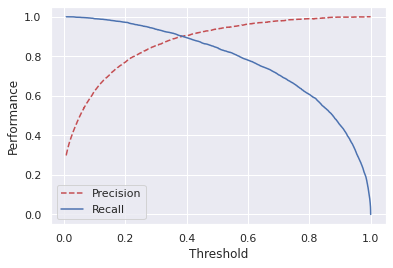

In [ ]:
# Threshold-PR curve
train_loss, y_true, y_prob = trainer.eval_step(dataloader=train_dataloader)
precisions, recalls, thresholds = precision_recall_curve(y_true.ravel(), y_prob.ravel())
plt.plot(thresholds, precisions[:-1], "r--", label="Precision")
plt.plot(thresholds, recalls[:-1], "b-", label="Recall")
plt.ylabel("Performance")
plt.xlabel("Threshold")
plt.legend(loc="best")

In [ ]:
# Determining the best threshold
def find_best_threshold(y_true, y_prob):
    """Find the best threshold for maximum F1."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    f1s = (2 * precisions * recalls) / (precisions + recalls)
    return thresholds[np.argmax(f1s)]

In [ ]:
# Best threshold for f1
threshold = find_best_threshold(y_true.ravel(), y_prob.ravel())
threshold

0.35685015

In [ ]:
# Determine predictions using threshold
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.723087173200577,
  "recall": 0.6914344685242518,
  "f1": 0.6994655315648542
}


In [ ]:
# Save artifacts
dir = Path("cnn")
dir.mkdir(parents=True, exist_ok=True)
tokenizer.save(fp=Path(dir, "tokenzier.json"))
label_encoder.save(fp=Path(dir, "label_encoder.json"))
torch.save(best_model.state_dict(), Path(dir, "model.pt"))
with open(Path(dir, "performance.json"), "w") as fp:
    json.dump(performance, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Load artifacts
device = torch.device("cpu")
tokenizer = Tokenizer.load(fp=Path(dir, "tokenzier.json"))
label_encoder = LabelEncoder.load(fp=Path(dir, "label_encoder.json"))
model = CNN(
    embedding_dim=embedding_dim, vocab_size=vocab_size,
    num_filters=num_filters, filter_sizes=filter_sizes,
    hidden_dim=hidden_dim, dropout_p=dropout_p,
    num_classes=num_classes)
model.load_state_dict(torch.load(Path(dir, "model.pt"), map_location=device))
model.to(device)

CNN(
  (embeddings): Embedding(39, 504, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(504, 472, kernel_size=(1,), stride=(1,))
    (1): Conv1d(504, 472, kernel_size=(2,), stride=(1,))
    (2): Conv1d(504, 472, kernel_size=(3,), stride=(1,))
    (3): Conv1d(504, 472, kernel_size=(4,), stride=(1,))
    (4): Conv1d(504, 472, kernel_size=(5,), stride=(1,))
    (5): Conv1d(504, 472, kernel_size=(6,), stride=(1,))
    (6): Conv1d(504, 472, kernel_size=(7,), stride=(1,))
    (7): Conv1d(504, 472, kernel_size=(8,), stride=(1,))
    (8): Conv1d(504, 472, kernel_size=(9,), stride=(1,))
    (9): Conv1d(504, 472, kernel_size=(10,), stride=(1,))
  )
  (dropout): Dropout(p=0.6065003167861672, inplace=False)
  (fc1): Linear(in_features=4720, out_features=387, bias=True)
  (fc2): Linear(in_features=387, out_features=12, bias=True)
)

In [ ]:
# Trainer module
trainer = Trainer(model=model, device=device)

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Data to evaluate
device = torch.device("cuda")
loss_fn = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
trainer = Trainer(model=model.to(device), device=device, loss_fn=loss_fn)
test_loss, y_true, y_prob = trainer.eval_step(dataloader=test_dataloader)
y_pred = np.array([np.where(prob >= threshold, 1, 0) for prob in y_prob])

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_true))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.723087173200577,
    "recall": 0.6914344685242518,
    "f1": 0.6994655315648542,
    "num_samples": 563.0
}


In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "First Party Collection/Use"
print (json.dumps(metrics["class"][tag], indent=2))

{
  "precision": 0.7195571955719557,
  "recall": 0.8552631578947368,
  "f1": 0.781563126252505,
  "num_samples": 228.0
}


In [ ]:
# Number of training samples per class
num_samples = np.sum(y_train, axis=0).tolist()

In [ ]:
# Number of samples vs. performance (per class)
f1s = [metrics["class"][_class]["f1"]*100. for _class in label_encoder.classes]
sorted_lists = sorted(zip(*[num_samples, f1s])) # sort
num_samples, f1s = list(zip(*sorted_lists))

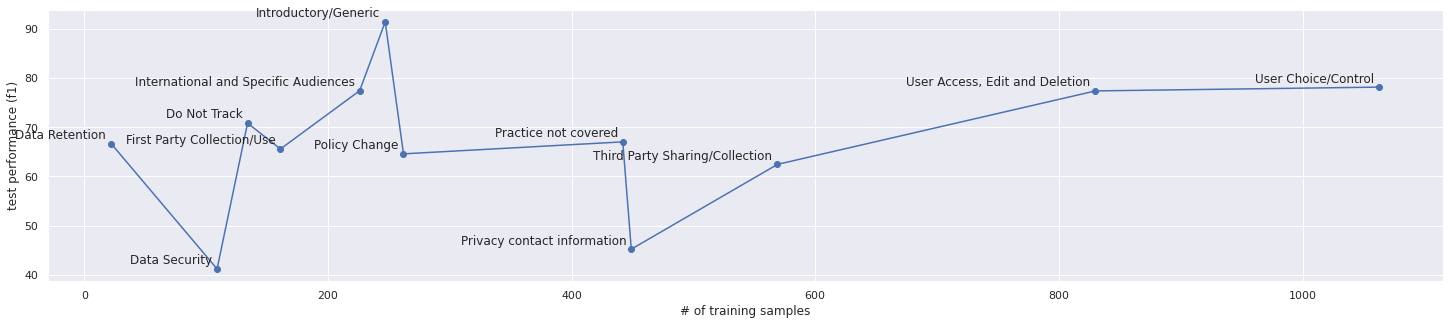

In [ ]:
# Plot
n = 12 # num. top classes to label
fig, ax = plt.subplots()
ax.set_xlabel("# of training samples")
ax.set_ylabel("test performance (f1)")
fig.set_size_inches(25, 5)
ax.plot(num_samples, f1s, "bo-")
for x, y, label in zip(num_samples[-n:], f1s[-n:], label_encoder.classes[-n:]):
    ax.annotate(label, xy=(x,y), xytext=(-5, 5), ha="right", textcoords="offset points")

In [ ]:
# TP, FP, FN samples
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i in range(len(y_test)):
    true = y_test[i][index]
    pred = y_pred[i][index]
    if true and pred:
        tp.append(i)
    elif not true and pred:
        fp.append(i)
    elif true and not pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

[0, 2, 6, 7, 13, 17, 18, 19, 28, 29, 34, 36, 37, 41, 42, 43, 44, 45, 46, 48, 49, 53, 55, 56, 61, 68, 69, 73, 77, 82, 86, 99, 100, 101, 109, 111, 115, 116, 117, 119, 126, 127, 128, 130, 136, 139, 144, 146, 147, 148, 149, 150, 151, 153, 166, 167, 171, 172, 174, 179, 180, 186, 188, 193, 195, 200, 205, 206, 207, 209, 215, 217, 224, 225, 227, 228, 230, 235, 236, 242, 243, 244, 245, 262, 267, 272, 276, 277, 279, 280, 284, 285, 286, 287, 288, 292, 293, 294, 304, 305, 307, 308, 309, 310, 312, 318, 319, 320, 327, 328, 332, 335, 336, 337, 338, 346, 347, 349, 356, 357, 358, 367, 369, 372, 377, 378, 379, 380, 381, 389, 397, 398, 400, 402, 408, 409, 411, 417, 418, 419, 425, 426, 427, 428, 434, 438, 439, 443, 444, 446, 448, 452, 453, 454, 463, 468, 469, 472, 474, 476, 478, 483, 484, 487, 494, 498, 499, 503, 504, 507, 508, 513, 520, 521, 523, 525, 532, 533, 535, 536, 538, 539, 541, 543, 544, 545, 546, 548, 549, 552, 553, 554, 555, 557, 558]
[9, 15, 23, 26, 33, 35, 40, 51, 60, 62, 63, 66, 67, 70, 72, 

In [ ]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}\n")

information sci news com may collect online sci news com may collect process following data information provide filling forms site including names e mail website addresses may also ask information purposes example report problem site
true: ['First Party Collection/Use']
pred: ['First Party Collection/Use']



In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))

In [ ]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag="First Party Collection/Use"):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))

    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i in range(len(y_test)):
        true = y_test[i][index]
        pred = y_pred[i][index]
        if true and pred:
            tp.append(i)
        elif not true and pred:
            fp.append(i)
        elif true and not pred:
            fn.append(i)

    # Samples
    num_samples = 3
    cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
    for item in cm:
        if len(item[0]):
            print (f"\n=== {item[1]} ===")
            for i in item[0][:num_samples]:
                print (f"  {X_test_raw[i]}")
                print (f"    true: {label_encoder.decode([y_test[i]])[0]}")
                print (f"    pred: {label_encoder.decode([y_pred[i]])[0]}\n")

interactive(children=(Dropdown(description='tag', index=1, options=('International and Specific Audiences', 'F…

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def pytorch_transformers(x):
    """Projects with the `pytorch` and `transformers` tags."""
    return all(tag in x.category for tag in ["First Party Collection/Use", "Third Party Sharing/Collection"])

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.segment_text.split()) < 7  # less than 7 words

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["segment_text", "category"]].head()

100%|██████████| 563/563 [00:00<00:00, 24909.74it/s]


,segment_text,category
5,redorbit inc privacy statement,[Introductory/Generic]
14,third party cookies,[Introductory/Generic]
112,privacy policy,[Introductory/Generic]
118,privacy policy,[Introductory/Generic]
124,document last revised 09292011,[Policy Change]


In [ ]:
# Slices
slicing_functions = [pytorch_transformers, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

100%|██████████| 563/563 [00:00<00:00, 20157.35it/s]


rec.array([(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 1), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (1, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (1, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (1, 0), (0, 0), (0, 0),
           (0, 0), (0, 0)

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_true[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

{
  "pytorch_transformers": {
    "precision": 0.8602941176470589,
    "recall": 0.6842105263157895,
    "f1": 0.762214983713355,
    "num_samples": 70
  },
  "short_text": {
    "precision": 0.75,
    "recall": 0.8571428571428571,
    "f1": 0.7999999999999999,
    "num_samples": 16
  }
}
